In [4]:
# import neccessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import random_split,DataLoader,Dataset,TensorDataset
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [152]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [122]:
tranform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
                             )

The three values (0.5, 0.5, 0.5) in both tuples inside transforms.Normalize() correspond to the three color channels in an RGB image.

Breakdown:
First tuple (mean): (0.5, 0.5, 0.5)

This specifies the mean used to normalize each channel (Red, Green, Blue).

Second tuple (std): (0.5, 0.5, 0.5)
This specifies the standard deviation used to normalize each channel.

In [124]:
training_dataset=datasets.CIFAR10(root="data",download=True,transform=tranform,train=True)
test_dataset=datasets.CIFAR10(root="data",download=True,transform=tranform,train=False)

In [126]:
len(training_dataset),len(test_dataset)

(50000, 10000)

In [128]:
train_loader=DataLoader(training_dataset,shuffle=True,batch_size=100)
test_loader=DataLoader(test_dataset,shuffle=True,batch_size=100)

In [130]:
#visualize

for i,(images,labels) in enumerate(train_loader):
    print(images.shape)
    print(labels.shape)
    break

torch.Size([100, 3, 32, 32])
torch.Size([100])


### explanation:


* Since many datasets normalize images using mean=0.5, std=0.5, we reverse it by img = img / 2 + 0.5.

* PyTorch tensors typically have the shape [C, H, W], but Matplotlib expects [H, W, C]. This is fixed by np.transpose(npimg, (1, 2, 0)).

* c=channel,h=height, and w =width


### What Does This Do? The normalization formula applied to each pixel is:


normalized_pixel= (original_pixel−mean) / std


(Since pixel values in PyTorch tensors (after ToTensor()) range from 0 to 1, normalization transforms them to a range between -1 and 1 using)

normalized_pixel=  ( original_pixel−0.5)/0.5
 
Which simplifies to:

normalized_pixel=2×original_pixel−1

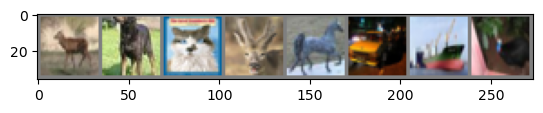

In [158]:
#100 is batchsize,3 channel size (r,g,b), 32*32 pixel

def imshow(img):
    img=img/2+0.5 #unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()


imshow(torchvision.utils.make_grid(images[:8]))

In [43]:
lables[:8]

tensor([7, 0, 9, 7, 9, 2, 5, 2])

In [134]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

[classes[i] for i in labels[:8]]

['dog', 'car', 'truck', 'dog', 'car', 'horse', 'car', 'plane']

In [136]:
#build a model

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network=nn.Sequential(
            nn.Conv2d(3,32,kernel_size=(3,3),padding="same"), #here 3 channels of 32*32 images , 32 is filters >>output(32*32*32)32 channels,32 width and 32 height
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)),#grid changes to (32*16*16)
            nn.Conv2d(32,64,kernel_size=(3,3),padding="valid"), #here 32 channels of 16*16 images , 64 is filters >>output(64*16*16)64 channels,16 width and 16 height
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))#grid changes to (64*7*7) because we are not adding padding in the above so dimension changes to 64*14*14
        )
        self.fc_layers=nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7,600),
            nn.ReLU(),
            nn.Linear(600,120),
            nn.ReLU(),
            nn.Linear(120,10) )# 10 becuase we have 10 classes)


    def forward(self,x):
        x= self.network(x)
        x=self.fc_layers(x)
        return x
        
                     
        

In [138]:
device=torch.device("gpu" if torch.cuda.is_available() else "mps")
device

device(type='mps')

In [140]:
model=CNN().to(device)
model

CNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=600, bias=True)
    (2): ReLU()
    (3): Linear(in_features=600, out_features=120, bias=True)
    (4): ReLU()
    (5): Linear(in_features=120, out_features=10, bias=True)
  )
)

In [142]:
#hyper parameters

epochs=5
learning_rate=0.001

criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

In [148]:
total_step=len(train_loader)

for epoch in range(epochs):
    for i,(images,lables) in enumerate(train_loader):
        images=images.to(device)
        lables=lables.to(device)
        outputs=model(images)
        loss=criterion(outputs,lables)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if(i+1)%100 ==0:
            print(f"epoch [{epoch+1}/{epochs}], step [{i+1}/{total_step}], loss :{loss.item():.2f}")


model.eval()
with torch.no_grad():
    correct=0
    total=0
    for images,labels in test_loader:
        images=images.to(device)
        labels=labels.to(device)
        outputs=model(images)
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()

    print(f"accuracy of the model on the 10000 is {100* correct/total:.2f}")

epoch [1/5], step [100/500], loss :0.15
epoch [1/5], step [200/500], loss :0.02
epoch [1/5], step [300/500], loss :0.08
epoch [1/5], step [400/500], loss :0.11
epoch [1/5], step [500/500], loss :0.17
epoch [2/5], step [100/500], loss :0.02
epoch [2/5], step [200/500], loss :0.02
epoch [2/5], step [300/500], loss :0.19
epoch [2/5], step [400/500], loss :0.04
epoch [2/5], step [500/500], loss :0.14
epoch [3/5], step [100/500], loss :0.04
epoch [3/5], step [200/500], loss :0.18
epoch [3/5], step [300/500], loss :0.11
epoch [3/5], step [400/500], loss :0.19
epoch [3/5], step [500/500], loss :0.03
epoch [4/5], step [100/500], loss :0.06
epoch [4/5], step [200/500], loss :0.04
epoch [4/5], step [300/500], loss :0.04
epoch [4/5], step [400/500], loss :0.05
epoch [4/5], step [500/500], loss :0.14
epoch [5/5], step [100/500], loss :0.01
epoch [5/5], step [200/500], loss :0.05
epoch [5/5], step [300/500], loss :0.01
epoch [5/5], step [400/500], loss :0.05
epoch [5/5], step [500/500], loss :0.05


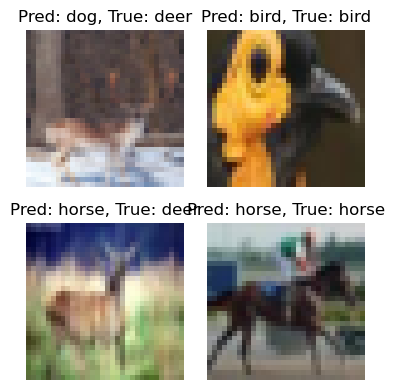

In [195]:
# Plot the first 9 images with predictions and true labels

model.eval()
with torch.no_grad():
    correct=0
    total=0
    for images,labels in test_loader:
        images=images.to(device)
        labels=labels.to(device)
        outputs=model(images)
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
    plt.figure(figsize=(4, 4))
    for i in range(4):
        plt.subplot(2, 2, i+1)
        images[i]=images[i]/2+0.5 #unnormalize
        npimg = images[i].cpu().numpy()
        plt.imshow(np.transpose(npimg,(1,2,0)))
        plt.title(f"Pred: {classes[predicted[i].item()]}, True: {classes[labels[i].item()]}")
        plt.axis('off')
        plt.tight_layout()
    plt.show()